import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# ^^^ pyforest auto-imports - don't write above this line
Notebook to see how well movement is removed from the edge time series. This will show us whether we have to include movement regressors or not

In [3]:
import numpy as np
import matplotlib.pylab as plt
import pandas as pd
import sys
sys.path.append("..")

import gc
from tqdm import tqdm

from joblib import Parallel, delayed
from scipy.spatial.distance import squareform
import ptitprince as pt
import seaborn as sns
from os.path import join as opj
from pathlib import Path
from scipy.stats import pearsonr

from nilearn import glm
from nilearn.input_data import NiftiLabelsMasker

#from cofluctuate_bold_glm import NiftiEdgeAtlas
from src.cofluctuate_bold import NiftiEdgeAtlas
from src import get_denoise_opts
from src.input_data import get_bold_files, get_confounders_df

In [17]:
# Shen Atlas
atlas_file = "../data/atlases/shen_2mm_268_parcellation.nii.gz"
print("atlas file: ", atlas_file)

# Get denoise options
denoise_opts = get_denoise_opts()
#del denoise_opts['fir_delays']
#Subject to use
subjects_used = np.loadtxt("../data/subjects_intersect_motion_035.txt")
print("first 10 subjects: ", subjects_used[:10])

event_file = "../data/task-stroop_events.tsv"
print("events file: ", event_file)

atlas file:  ../data/atlases/shen_2mm_268_parcellation.nii.gz
getting denoise options:  {'t_r': 2.0, 'high_pass': 0.0053475935828877, 'detrend': False, 'fir_delays': [1, 2, 3, 4, 5, 6, 7, 8, 9]}
first 10 subjects:  [2049. 2050. 1026. 1028. 2055. 2058. 2059. 2060. 2062. 2063.]
events file:  ../data/task-stroop_events.tsv


In [18]:
denoise_opts

{'t_r': 2.0,
 'high_pass': 0.0053475935828877,
 'detrend': False,
 'fir_delays': [1, 2, 3, 4, 5, 6, 7, 8, 9]}

In [5]:
def get_patterns(task_id):
    """
    Function to get patterns for data
    """
    data_dir = "../data"
    base_file = "sub-%d_ses-01" + "_task-%s" % task_id
    
    run_img_pattern = opj(data_dir, 
                          "preproc_bold/task-%s" % task_id,
                          base_file + "_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz")
    
    confounders_pattern = opj(data_dir,
                              "confounders/task-%s" % task_id,
                              base_file + "_desc-confounds_regressors.tsv")
    
    return run_img_pattern, confounders_pattern

# MOTION

In [23]:
def compute_corrs_edges(run_img, conf_file, regex):
    conf_df = pd.read_csv(conf_file, sep="\t" ).filter(regex=regex).fillna(0)
    
    #nifti_label = NiftiLabelsMasker(labels_img=atlas_file, **denoise_opts)
    nifti_label = NiftiEdgeAtlas(atlas_file=atlas_file, **denoise_opts)
    #roi_ts = nifti_label.fit_transform(imgs=run_img, confounds = conf_df)
    _ = nifti_label.fit_transform(run_img=run_img, confounds= conf_df, events=event_file)
    roi_ts = nifti_label.atlas_roi_denoised_
    corrs = np.corrcoef(roi_ts.T)
    return squareform(corrs, checks=False)

def compute_corrs_pipeline(pipe_regexs_dict, run_img_pattern, confounders_pattern):
    corrs_pipe_dict = dict()
    for name, regex in tqdm(pipe_regexs_dict.items()):
    
        parallel = Parallel(n_jobs=15) # Run this in parallel
        list_corrs = parallel(delayed(compute_corrs_edges)(run_img = run_img_pattern % subj, 
                                                           conf_file = confounders_pattern % subj,
                                                           regex=regex) for subj in subjects_used)
        corrs_pipe_dict[name] = np.array(list_corrs)

    return corrs_pipe_dict

def get_fwd_vector(confounders_pattern):
    fwd = []
    n_outliers = []
    for subj in subjects_used:
        fwd.append(pd.read_csv(confounders_pattern % subj, sep="\t").framewise_displacement.dropna().mean())
        n_outliers.append(pd.read_csv(confounders_pattern % subj, sep="\t").filter(regex="motion").shape[1])
    fwd = np.array(fwd)
    n_outliers = np.array(n_outliers)
    
    #Plot fwd-n_outliers frames
    plt.figure()
    sns.regplot(n_outliers, fwd)
    plt.xlabel("Number of outliers")
    plt.ylabel("Framewise displacement")
    plt.show()
    
    return fwd
    

def plots_qc_fc(corrs_pipe_dict, fwd, output_dir):
    fc_qc_df = pd.DataFrame({})
    for key in corrs_pipe_dict.keys():
        fc_qc_df[key] = [np.corrcoef(corrs, fwd)[0,1] for corrs in corrs_pipe_dict[key].T]
        
    # KDE Plots
    plt.figure(figsize=(10,5))
    for case in fc_qc_df.columns:
        sns.kdeplot(fc_qc_df.loc[:, case].to_list(), label=case)
    plt.legend()
    plt.ylabel("Densitiy", size=20)
    plt.xlabel("FC-FWD Pearson correlations", size=20)
    plt.tick_params(labelsize=15)
    #plt.savefig(opj(output_dir, "fc_fwd_density.png"), dpi=300)
    plt.show()

    fig, ax = plt.subplots(figsize=(12, 8))
    pt.RainCloud(x='fake', hue='variable', y='value', 
                 data = pd.concat([pd.DataFrame({'fake': [1]*pd.melt(fc_qc_df).shape[0]}),
                                   pd.melt(fc_qc_df)], axis=1), 
                 orient='h', 
                 ax=ax,
                 pointplot=True,
                 alpha = .5,
                 width_viol = .7,
                 dodge = True)
    plt.ylabel(" ")
    plt.xlabel("FC-FWD Pearson correlations", size=20)
    plt.tick_params(labelsize=15)
    #plt.savefig(opj(output_dir, "fc_fwd_rainclouds_together.png"), dpi=300)
    plt.show()
    
    fig, ax = plt.subplots(figsize=(12, 8))
    pt.RainCloud(x='variable', y='value', data =pd.melt(fc_qc_df), 
                 orient='h', 
                 ax=ax,
                 pointplot=True,
                 width_viol = .7,
                 dodge = True)
    plt.ylabel("Denoise Pipeline", size=20)
    plt.xlabel("FC-FWD Pearson correlations", size=20)
    plt.tick_params(labelsize=15)
    #plt.savefig(opj(output_dir, "fc_fwd_rainclouds_separated.png"), dpi=300)
    plt.show()
    
    
def get_pipelines(which_case ='all'):
    pipe_regexs_dict = dict()
    pipe_regexs_dict["6MP"] = "trans_[x-z]$|rot_[x-z]$" # 6 motion parameters
    pipe_regexs_dict["24MP"] = "trans|rot" # 24 motion parameters,
    pipe_regexs_dict["24MP_2PHYS"] = "trans|rot|white_matter$|csf$"#, # 24 motion parameters + WM + CSF
    pipe_regexs_dict["24MP_8PHYS"] = "trans|rot|white_matter|csf"#, # 24 motion parameters + WM + CSF
    pipe_regexs_dict["24MP_ACOR"] =  "trans|rot|a_comp_cor_0[0-9]" # 24 motion parameters + 10 CompCor components
    pipe_regexs_dict["26MP_2PHYS"] = "trans|rot|white_matter$|csf$|rmsd|^dvars$"#, # 24 motion parameters + WM + CSF
    #pipe_regexs_dict["26MP_2PHYS_MOTION"] = "trans|rot|white_matter$|csf$|motion_outlier"#, # 24 motion parameters + WM + CSF
    
    if which_case == 'all':
        dict_to_return = pipe_regexs_dict
    else:
        dict_to_return = dict()
        dict_to_return[which_case] = pipe_regexs_dict[which_case]

    return dict_to_return

def run_case(task_id):
    # 1-Get pipeline regex to filter the confounders (this is independent of the task)
    print("Getting pipeline regex to filter the confounders (this is independent of the task)")
    pipe_regexs_dict = get_pipelines(which_case="all")
    
    print(pipe_regexs_dict)
    print(" ")
    
    # 2-Define file patterns for the given task
    print("Getting images and confounders file patterns")
    run_img_pattern, confounders_pattern = get_patterns(task_id)
    
    print("run_img_pattern:", run_img_pattern)
    print("confounders_pattern:", confounders_pattern)
    print(" ")

    # 3- Get FWD vector
    print("Getting FWD")
    fwd = get_fwd_vector(confounders_pattern)

    # 4- Compute correlations of parcellated time series, after denoising.
    print("Computing correlations")
    
    corrs_pipe_dict = compute_corrs_pipeline(pipe_regexs_dict = pipe_regexs_dict, 
                                             run_img_pattern = run_img_pattern, 
                                             confounders_pattern = confounders_pattern)
    # 5- Generate plots
    print("Generating plots")
    output_dir = "../plots/qc/task-%s" % task_id
    Path(output_dir).mkdir(parents=True, exist_ok=True)
    plots_qc_fc(corrs_pipe_dict = corrs_pipe_dict, fwd = fwd, output_dir = output_dir)
    
    

Getting pipeline regex to filter the confounders (this is independent of the task)
{'6MP': 'trans_[x-z]$|rot_[x-z]$', '24MP': 'trans|rot', '24MP_2PHYS': 'trans|rot|white_matter$|csf$', '24MP_8PHYS': 'trans|rot|white_matter|csf', '24MP_ACOR': 'trans|rot|a_comp_cor_0[0-9]', '26MP_2PHYS': 'trans|rot|white_matter$|csf$|rmsd|^dvars$'}
 
Getting images and confounders file patterns
run_img_pattern: ../data/preproc_bold/task-stroop/sub-%d_ses-01_task-stroop_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
confounders_pattern: ../data/confounders/task-stroop/sub-%d_ses-01_task-stroop_desc-confounds_regressors.tsv
 
Getting FWD


/home/javi/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


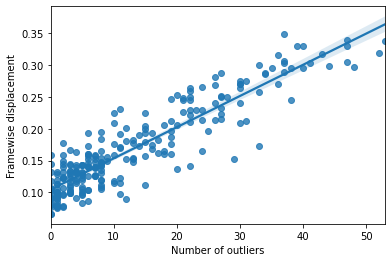

  0%|          | 0/6 [00:00<?, ?it/s]

Computing correlations


100%|██████████| 6/6 [15:19<00:00, 153.29s/it]


Generating plots


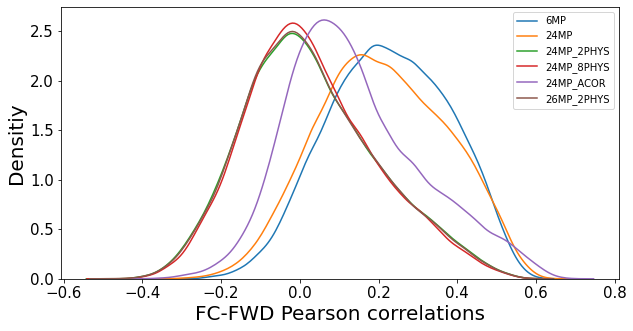

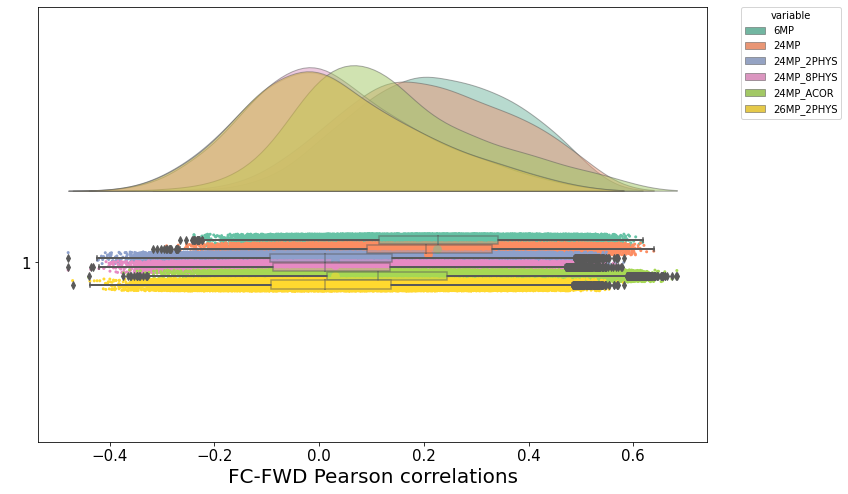

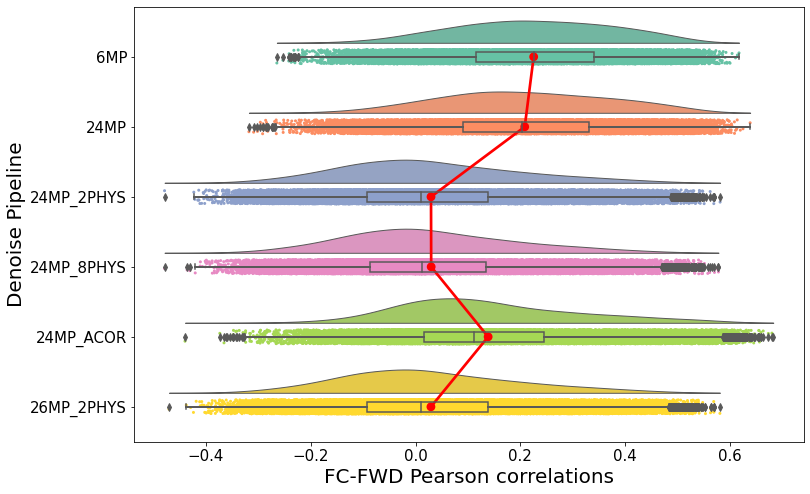

In [24]:
run_case(task_id = "stroop")

Getting pipeline regex to filter the confounders (this is independent of the task)
{'24MP_2PHYS': 'trans|rot|white_matter$|csf$', '26MP_2PHYS_MOTION': 'trans|rot|white_matter$|csf$|motion_outlier'}
 
Getting images and confounders file patterns
run_img_pattern: ../data/preproc_bold/task-msit/sub-%d_ses-01_task-msit_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
confounders_pattern: ../data/confounders/task-msit/sub-%d_ses-01_task-msit_desc-confounds_regressors.tsv
 
Getting FWD


/home/javi/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


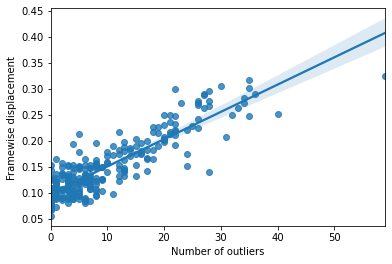

  0%|          | 0/2 [00:00<?, ?it/s]

Computing correlations


100%|██████████| 2/2 [06:09<00:00, 184.52s/it]


Generating plots


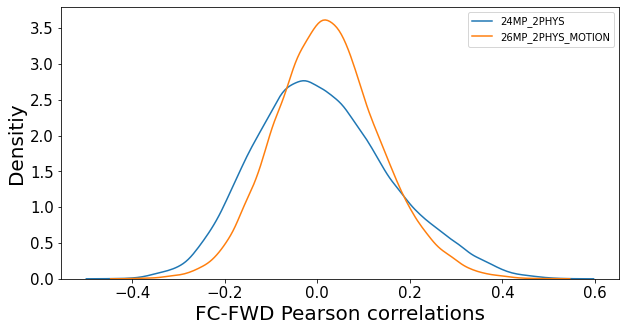

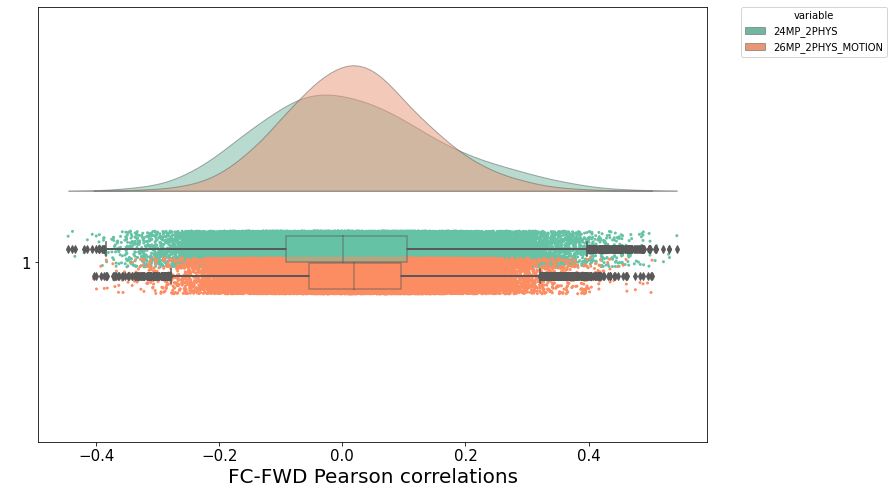

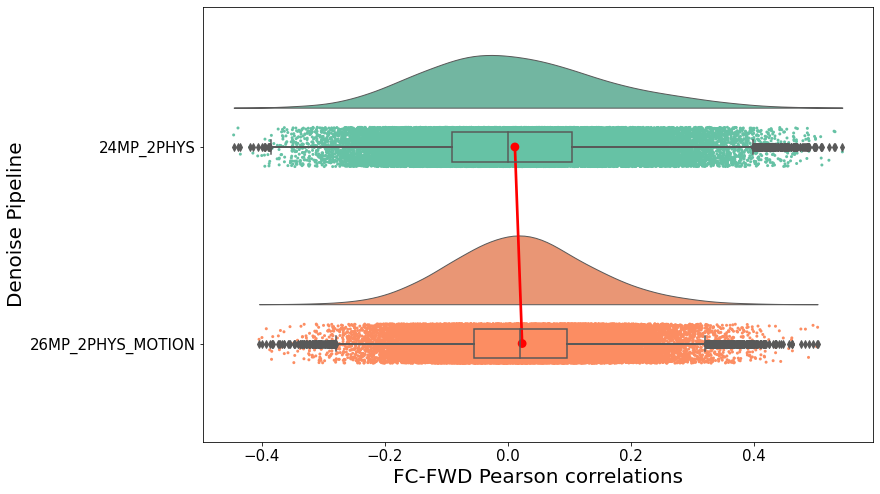

In [6]:
run_case(task_id = "msit")

So it seems that, at least for stroop and msit, the best strategy is for motion reduction is motion 24MP + WM + CSF in both cases!

Getting pipeline regex to filter the confounders (this is independent of the task)
{'24MP_2PHYS': 'trans|rot|white_matter$|csf$', '26MP_2PHYS_MOTION': 'trans|rot|white_matter$|csf$|motion_outlier'}
 
Getting images and confounders file patterns
run_img_pattern: ../data/preproc_bold/task-rest/sub-%d_ses-01_task-rest_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
confounders_pattern: ../data/confounders/task-rest/sub-%d_ses-01_task-rest_desc-confounds_regressors.tsv
 
Getting FWD


/home/javi/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


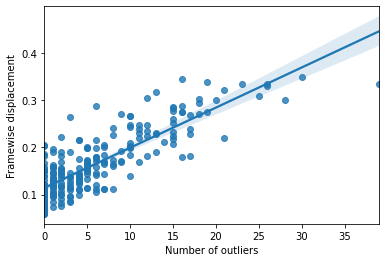

  0%|          | 0/2 [00:00<?, ?it/s]

Computing correlations


100%|██████████| 2/2 [03:16<00:00, 98.06s/it]


Generating plots


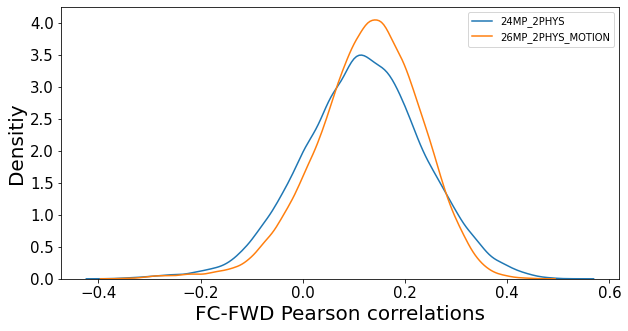

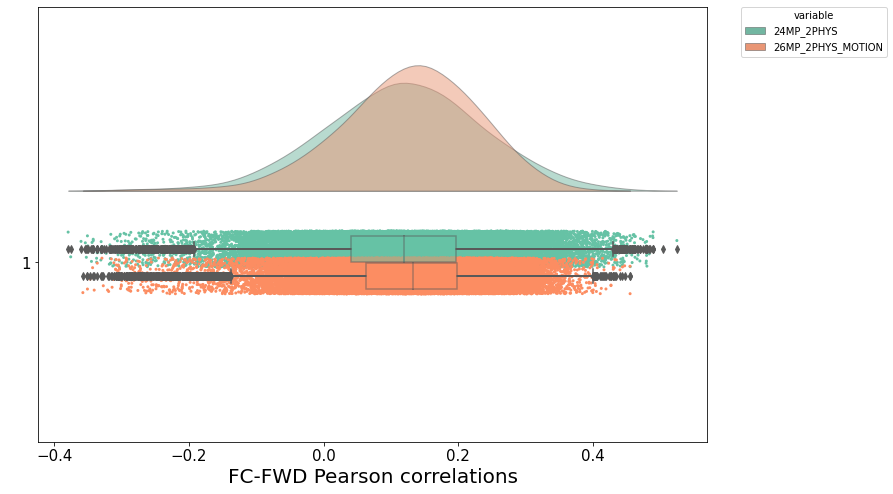

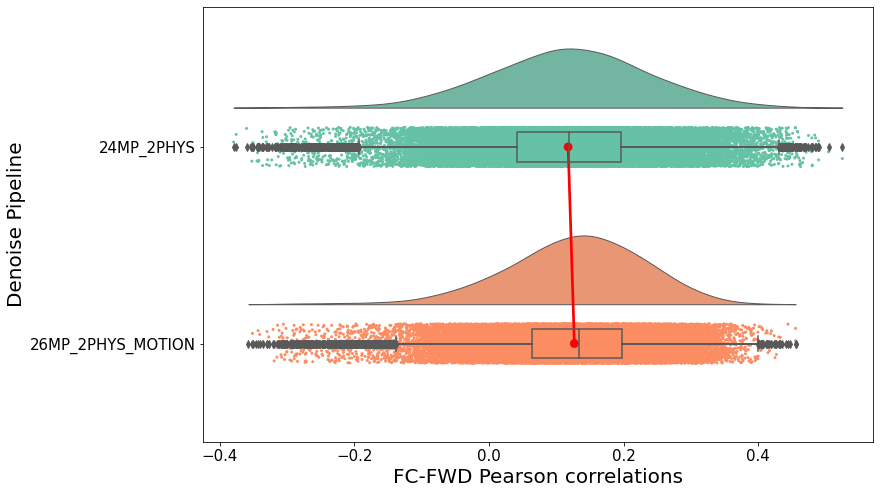

In [7]:
run_case(task_id = "rest")

We can see that it's no sufficient in resting! mmm... What should I do then? We can just live with this and acknolewdge as a limitation

# CONFOUNDERS (ATLAS)

Check that confounders are regressed out from the edge time series effectively

In [28]:
pipe_filter_regex = "trans|rot|white_matter$|csf$"

In [35]:
#from nilearn.signal import butterworth

def cormat_bold_conf(roi_ts, conf):
    """
    Compute correlation matrix betw
    """
    from sklearn.preprocessing import StandardScaler

    roi_ts_ss = StandardScaler().fit_transform(roi_ts)
    conf_ss = StandardScaler().fit_transform(conf)
    
    cor_mat = np.matmul(roi_ts_ss.transpose(), conf_ss)
    return cor_mat


def max_ts_conf_cors(run_img, conf_df, events, atlas_file, this_denoise_opts):
    
        edge_atlas = NiftiEdgeAtlas(atlas_file=atlas_file, **this_denoise_opts)
        edge_atlas_img = edge_atlas.fit_transform(run_img=run_img, events=events, confounds=conf_df)
        
        # the denoise takes place from the band-pass filtered
        # confoudnres, so i need to explicit band-pass them here      
        #conf_filtered = butterworth(conf_df.to_numpy(), 
         #                           sampling_rate = 1./denoise_opts['t_r'],
          #                          high_pass = denoise_opts['high_pass'])
        
        #cor_mat = cormat_bold_conf(edge_atlas.atlas_ts_conf_, conf_filtered)
        cor_mat = cormat_bold_conf(edge_atlas.atlas_roi_denoised_, conf_df.to_numpy())
        
        return np.max(np.abs(cor_mat))

def run_conf_denoitse_case(task_id, n_jobs=10):
    # Get files and confounders dataframes
    print("running task denoising QC for task %s" % task_id)
    run_img_pattern, confounders_pattern = get_patterns(task_id)
    
    run_imgs = [run_img_pattern % subj for subj in subjects_used]
    confounders_df = [pd.read_csv(confounders_pattern % subj, sep="\t") for subj in subjects_used]
    confounders_df = [conf_df.filter(regex=pipe_filter_regex).fillna(0) for conf_df in confounders_df]
    
    if task_id=="rest":
        events = None
    else:
        events = event_file
        
    parallel = Parallel(n_jobs = n_jobs)
    
    max_cors = parallel(delayed(max_ts_conf_cors)(run_img=run_img, 
                                                  conf_df=conf_df, 
                                                  events = events,
                                                  atlas_file = atlas_file, 
                                                  this_denoise_opts= denoise_opts) \
                         for (run_img, conf_df) in tqdm(zip(run_imgs, confounders_df))
                        )
    
    epsilon = 1e-8
    
    print("the number of subjects fulflilling" 
          " the threshold is = %d" % (sum([cor < epsilon for cor in max_cors])))
    
    plt.figure()
    plt.hist(max_cors)
    plt.xlabel("minimum correlations per subject")
    plt.show()
    
    del parallel
    _ = gc.collect()    

running task denoising QC for task stroop


242it [02:33,  1.58it/s]


the number of subjects fulflilling the threshold is = 242


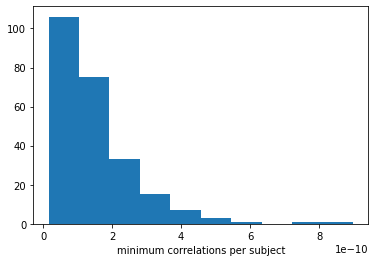

In [33]:
run_conf_denoitse_case(task_id = "stroop", n_jobs=-1)

running task denoising QC for task msit


242it [02:19,  1.74it/s]


the number of subjects fulflilling the threshold is = 242


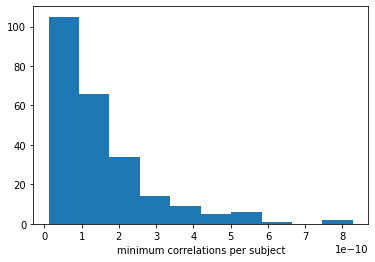

In [34]:
run_conf_denoitse_case(task_id = "msit", n_jobs=-1)

running task denoising QC for task rest


242it [01:17,  3.13it/s]


the number of subjects fulflilling the threshold is = 242


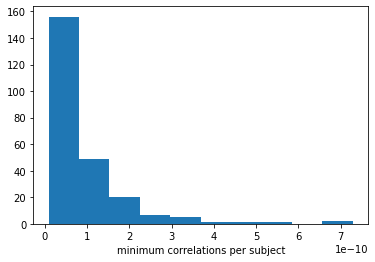

In [36]:
run_conf_denoitse_case(task_id = "rest", n_jobs=-1)

# HIGH-PASS FILTERING

Check that we are high-pass filtering low frequencies by looking at the power spectra of the time series

In [43]:
run_img_pattern, confounders_pattern = get_patterns("stroop")

run_imgs = [run_img_pattern % subj for subj in subjects_used]
confounders_df = [pd.read_csv(confounders_pattern % subj, sep="\t") for subj in subjects_used]
confounders_df = [conf_df.filter(regex=pipe_filter_regex).fillna(0) for conf_df in confounders_df]


In [180]:
edge_atlas = NiftiEdgeAtlas(atlas_file=atlas_file, detrend=False, high_pass=1/187, t_r=2.0)#**denoise_opts)
_ = edge_atlas.fit_transform(run_img=run_imgs[0], events=None, confounds=confounders_df[0])

In [173]:
edge_atlas.denoise_mat_[:,-9::].shape

(280, 9)

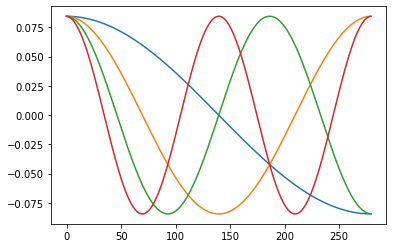

In [183]:
plt.plot(edge_atlas.denoise_mat_[:,-4::])

In [91]:
np.corrcoef(edge_atlas.atlas_roi_denoised_[:,0], edge_atlas.denoise_mat_[:,-4::][:,3])

array([[ 1.00000000e+00, -2.03400146e-14],
       [-2.03400146e-14,  1.00000000e+00]])

In [96]:
from nilearn.input_data import NiftiLabelsMasker

In [116]:
foo = NiftiLabelsMasker(labels_img=atlas_file, detrend=False, high_pass=1/187, t_r=2.0)
foo_img = foo.fit_transform(imgs=run_imgs[0], confounds=confounders_df[0])

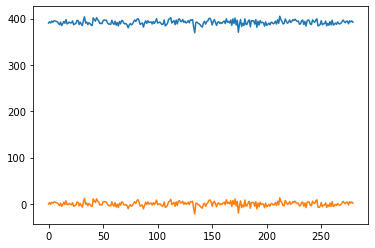

In [109]:
plt.plot(edge_atlas.atlas_roi_denoised_[:,0])
plt.plot(foo_img[:,0])

In [164]:
0.009

0.009

In [179]:
welch(edge_atlas.atlas_roi_denoised_[:,0], fs=1/2.0)

(array([0.        , 0.00195312, 0.00390625, 0.00585938, 0.0078125 ,
        0.00976562, 0.01171875, 0.01367188, 0.015625  , 0.01757812,
        0.01953125, 0.02148438, 0.0234375 , 0.02539062, 0.02734375,
        0.02929688, 0.03125   , 0.03320312, 0.03515625, 0.03710938,
        0.0390625 , 0.04101562, 0.04296875, 0.04492188, 0.046875  ,
        0.04882812, 0.05078125, 0.05273438, 0.0546875 , 0.05664062,
        0.05859375, 0.06054688, 0.0625    , 0.06445312, 0.06640625,
        0.06835938, 0.0703125 , 0.07226562, 0.07421875, 0.07617188,
        0.078125  , 0.08007812, 0.08203125, 0.08398438, 0.0859375 ,
        0.08789062, 0.08984375, 0.09179688, 0.09375   , 0.09570312,
        0.09765625, 0.09960938, 0.1015625 , 0.10351562, 0.10546875,
        0.10742188, 0.109375  , 0.11132812, 0.11328125, 0.11523438,
        0.1171875 , 0.11914062, 0.12109375, 0.12304688, 0.125     ,
        0.12695312, 0.12890625, 0.13085938, 0.1328125 , 0.13476562,
        0.13671875, 0.13867188, 0.140625  , 0.14

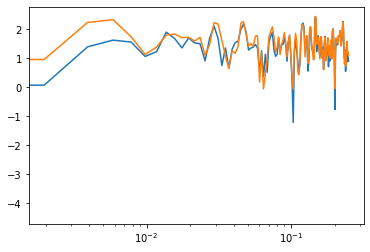

In [137]:
plt.plot(welch(foo_img[:,2], fs=1/2.0)[0], 
         np.log10(welch(foo_img[:,2], fs=1/2.0)[1]))
plt.xscale("log")

plt.plot(welch(edge_atlas.atlas_roi_denoised_[:,2], fs=1/2.0)[0], 
         np.log10(welch(edge_atlas.atlas_roi_denoised_[:,2], fs=1/2.0)[1]))
plt.xscale("log")

In [127]:
periodogram(foo_img[:,2], fs=1/2.0)[1]

array([5.76995405e-30, 8.25531740e-01, 7.01221978e+00, 1.07207767e+02,
       7.04650104e+01, 1.48590934e+01, 8.88769607e+00, 5.35416642e+01,
       3.14289884e+01, 5.20417073e+01, 3.14145342e+01, 9.98211750e+01,
       2.69618453e+01, 6.03937110e+01, 1.07698167e+02, 6.03484258e+01,
       5.98729136e+01, 6.35292190e+01, 9.80373474e+00, 8.56095685e+00,
       2.24225338e+01, 2.01358864e+00, 5.88119777e+01, 7.96785225e+01,
       6.43237456e+00, 5.47237382e+01, 5.90769208e+01, 5.32315109e+01,
       2.38174028e+01, 5.54421167e+00, 6.66235129e+01, 4.31226225e+00,
       4.05456386e+01, 2.02441521e+01, 1.68965729e+00, 5.95813809e+01,
       2.29133303e+01, 1.44757309e+00, 1.06539745e+01, 4.79750423e+01,
       3.77809293e+00, 2.96110482e+01, 8.47112187e+01, 2.78828300e+00,
       8.02506367e+01, 7.20620620e+01, 2.91836418e+01, 3.25139895e+00,
       1.01649687e+01, 5.00507374e+01, 3.95333198e+01, 1.54006754e+01,
       1.02096048e+01, 1.19031494e+01, 7.21460292e+01, 4.55266118e+01,
      

In [126]:
periodogram(edge_atlas.atlas_roi_denoised_[:,2], fs=1/2.0)[1]

array([1.40417602e-25, 3.38253280e+00, 7.37771342e+01, 2.24582028e+02,
       7.51280792e+00, 4.06355673e+01, 1.77476827e+01, 4.96745493e+01,
       2.07206812e+01, 6.71580419e+01, 1.39501802e+01, 4.84261237e+01,
       4.56131039e+01, 1.07600111e+02, 1.53778158e+02, 6.62978770e+01,
       5.25978636e+01, 8.73114501e+01, 6.27683731e+01, 2.48883167e+00,
       2.09664656e+01, 9.64606410e+00, 5.38034247e+01, 7.40958679e+01,
       6.42899449e-02, 9.88782654e+01, 1.00682599e+02, 3.78541561e+01,
       4.02419978e+01, 6.62401304e+00, 6.13807786e+01, 4.65823622e+00,
       8.42968927e+01, 2.18037191e+01, 1.35845415e-01, 5.22546070e+01,
       1.30030741e+01, 1.09397909e+00, 1.20593279e+01, 7.18251403e+01,
       5.85154898e+00, 3.94494634e+01, 9.59537411e+01, 3.03968926e+00,
       7.95501560e+01, 7.13688558e+01, 3.72005687e+01, 4.69219431e-01,
       1.60275833e+01, 5.27551318e+01, 7.43924179e+01, 8.42685174e+00,
       1.46277295e+01, 3.00486714e+01, 8.75791768e+01, 3.96213895e+01,
      

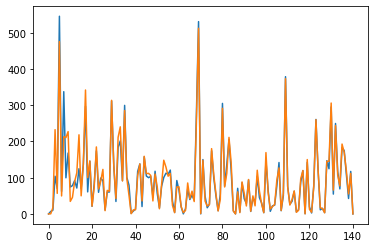

In [122]:
from scipy.signal import periodogram
plt.plot(periodogram(foo_img[:,0], fs=1/2.0)[1])
plt.plot(periodogram(edge_atlas.atlas_roi_denoised_[:,0], fs=1/2.0)[1])

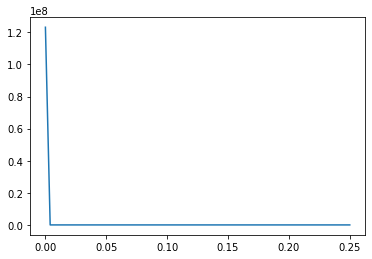

In [88]:
from scipy.signal import welch

plt.plot(welch(edge_atlas.atlas_roi_denoised_[:,5], fs=1/2.0, detrend=False, )[0],
         welch(edge_atlas.atlas_roi_denoised_[:,5], fs=1/2.0, detrend=False)[1])

In [ ]:
def max_ts_conf_cors(run_img, conf_df, events, atlas_file, this_denoise_opts):
    
    edge_atlas = NiftiEdgeAtlas(atlas_file=atlas_file, **this_denoise_opts)
    edge_atlas_img = edge_atlas.fit_transform(run_img=run_img, events=events, confounds=conf_df)

    # the denoise takes place from the band-pass filtered
    # confoudnres, so i need to explicit band-pass them here      
    #conf_filtered = butterworth(conf_df.to_numpy(), 
     #                           sampling_rate = 1./denoise_opts['t_r'],
      #                          high_pass = denoise_opts['high_pass'])

    #cor_mat = cormat_bold_conf(edge_atlas.atlas_ts_conf_, conf_filtered)
    cor_mat = cormat_bold_conf(edge_atlas.atlas_roi_denoised_, conf_df.to_numpy())

    return np.max(np.abs(cor_mat))

def run_conf_denoitse_case(task_id, n_jobs=10):
    # Get files and confounders dataframes
    print("running task denoising QC for task %s" % task_id)
    run_img_pattern, confounders_pattern = get_patterns(task_id)
    
    run_imgs = [run_img_pattern % subj for subj in subjects_used]
    confounders_df = [pd.read_csv(confounders_pattern % subj, sep="\t") for subj in subjects_used]
    confounders_df = [conf_df.filter(regex=pipe_filter_regex).fillna(0) for conf_df in confounders_df]
    
    if task_id=="rest":
        events = None
    else:
        events = event_file
        
    parallel = Parallel(n_jobs = n_jobs)
    
    max_cors = parallel(delayed(max_ts_conf_cors)(run_img=run_img, 
                                                  conf_df=conf_df, 
                                                  events = events,
                                                  atlas_file = atlas_file, 
                                                  this_denoise_opts= denoise_opts) \
                         for (run_img, conf_df) in tqdm(zip(run_imgs, confounders_df))
                        )
    
    epsilon = 1e-8
    
    print("the number of subjects fulflilling" 
          " the threshold is = %d" % (sum([cor < epsilon for cor in max_cors])))
    
    plt.figure()
    plt.hist(max_cors)
    plt.xlabel("minimum correlations per subject")
    plt.show()
    
    del parallel
    _ = gc.collect()    

# CONFOUNDERS (SEED)

Check that confounders are regressed out from the edge time series effectively in seed based case

In [59]:
from cofluctuate_bold_glm import NiftiEdgeSeed
import json

pipe_filter_regex = "trans|rot|white_matter$|csf$"
mask_file = "../data/masks/grey_mask_motion_035.nii.gz"

In [71]:
from nilearn.signal import butterworth

def cormat_bold_conf(roi_ts, conf):
    """
    Compute correlation matrix betw
    """
    from sklearn.preprocessing import StandardScaler

    roi_ts_ss = StandardScaler().fit_transform(roi_ts)
    conf_ss = StandardScaler().fit_transform(conf)
    
    cor_mat = np.matmul(roi_ts_ss.transpose(), conf_ss)
    return cor_mat


def max_ts_conf_cors(run_img, conf_df, seed, radius, mask_file, smoothing_fwhm, this_denoise_opts):
    
        edge_seed = NiftiEdgeSeed(seed = seed, 
                                  radius = radius, 
                                  mask_img = mask_file, 
                                  smoothing_fwhm = smoothing_fwhm, 
                                  **this_denoise_opts)
        edge_seed_img = edge_seed.fit_transform(run_img=run_img, events=None, confounds=conf_df)
        
        # the denoise takes place from the band-pass filtered
        # confoudnres, so i need to explicit band-pass them here      
        conf_filtered = butterworth(conf_df.to_numpy(), 
                                    sampling_rate = 1./denoise_opts['t_r'],
                                    high_pass = denoise_opts['high_pass'])
        # Correlation between confounders and whole-brain cleaned time series
        cor_mat_brain = cormat_bold_conf(edge_seed.brain_ts_conf_, conf_filtered)
        # Correlation between confounders and seed-region cleaned time series
        cor_mat_seed = cormat_bold_conf(edge_seed.seed_ts_conf_, conf_filtered)
        
        return np.max(np.abs(cor_mat_brain)), np.max(np.abs(cor_mat_seed))

def run_conf_denoise_seed_case(task_id, n_jobs=10):
    # Get files and confounders dataframes
    print("running task denoising QC for task %s" % task_id)
    run_img_pattern, confounders_pattern = get_patterns(task_id)
    
    run_imgs = [run_img_pattern % subj for subj in subjects_used]
    confounders_df = [pd.read_csv(confounders_pattern % subj, sep="\t") for subj in subjects_used]
    confounders_df = [conf_df.filter(regex=pipe_filter_regex).fillna(0) for conf_df in confounders_df]
    
    # Read seeds for the given task
    
    peaks_dir = "../results/second-level/node/task-%s/Incongruent-Congruent/" % task_id
    with open(opj(peaks_dir, "peaks.json"), "r") as f:
        peaks_dict = json.load(f)
    
    epsilon = 1e-10 # (small) threshold to determine whether there's correlation or not
    for peak_type in ["positive", "negative"]:
        print("peak type : %s" % peak_type)
        peak_coords = tuple(list(peaks_dict[peak_type]))

        parallel = Parallel(n_jobs = n_jobs)

        max_cors_res = parallel(delayed(max_ts_conf_cors)(run_img=run_img, 
                                                          conf_df=conf_df, 
                                                          seed = peak_coords,
                                                          radius = 8.0,
                                                          mask_file = mask_file, 
                                                          smoothing_fwhm = 6.0,
                                                          this_denoise_opts= denoise_opts) \
                             for (run_img, conf_df) in tqdm(zip(run_imgs, confounders_df))
                            )
        max_cors_brain, max_cors_seed = zip(*max_cors_res)

        print("the number of subjects fulflilling " 
              " the threshold is = %d for the whole-brain" % (sum([cor < epsilon for cor in max_cors_brain])))
        print("the number of subjects fulflilling " 
              " the threshold is = %d for the seed-region" % (sum([cor < epsilon for cor in max_cors_seed])))

        fig, axs = plt.subplots(ncols=2, figsize = (10, 5))
        axs[0].hist(max_cors_brain)
        axs[0].set_xlabel("Maximum correlations per subject")
        axs[0].set_title("Whole-brain", size=20)
        
        axs[1].hist(max_cors_seed)
        axs[1].set_xlabel("Maximum correlations per subject")
        axs[1].set_title("%s seed Region" % peak_type, size=20)
        
        plt.tight_layout()
        plt.show()
        
        del parallel
        _ = gc.collect()    

running task denoising QC for task stroop




0it [00:00, ?it/s]

peak type : positive




20it [00:00, 64.62it/s]

20it [00:17, 64.62it/s]

40it [00:21,  3.04it/s]

60it [00:37,  2.16it/s]

80it [01:05,  1.33it/s]

100it [01:35,  1.03it/s]

120it [02:00,  1.05s/it]

140it [02:27,  1.14s/it]

160it [02:54,  1.20s/it]

180it [03:17,  1.19s/it]

200it [03:42,  1.21s/it]

220it [04:01,  1.14s/it]

259it [04:28,  1.04s/it]


the number of subjects fulflilling  the threshold is = 259 for the whole-brain
the number of subjects fulflilling  the threshold is = 259 for the seed-region


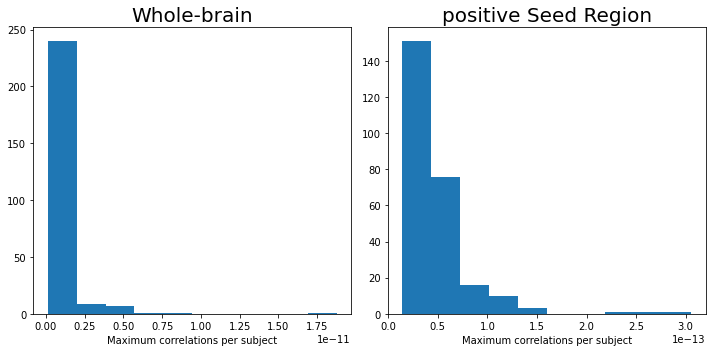

59it [14:56, 15.19s/it]
0it [00:00, ?it/s]

peak type : negative


259it [04:22,  1.01s/it]


the number of subjects fulflilling  the threshold is = 259 for the whole-brain
the number of subjects fulflilling  the threshold is = 259 for the seed-region


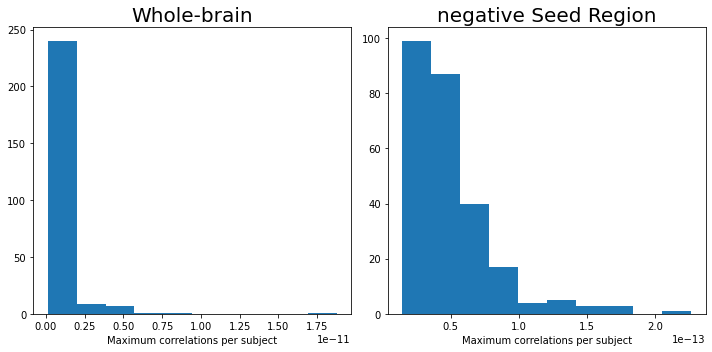

In [70]:
run_conf_denoise_seed_case(task_id = "stroop", n_jobs=20)

running task denoising QC for task msit


0it [00:00, ?it/s]

peak type : positive


259it [04:25,  1.03s/it]


the number of subjects fulflilling  the threshold is = 259 for the whole-brain
the number of subjects fulflilling  the threshold is = 259 for the seed-region


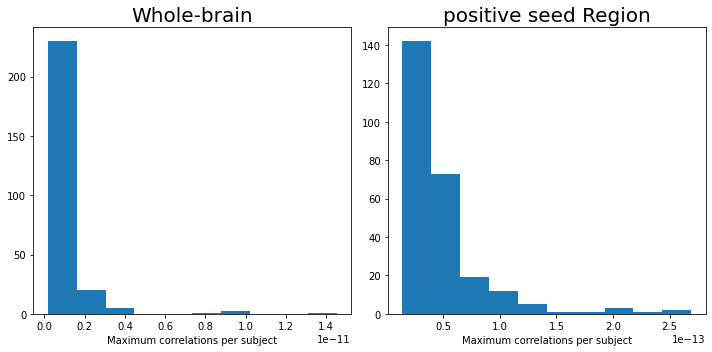

0it [00:00, ?it/s]

peak type : negative


259it [04:24,  1.02s/it]


the number of subjects fulflilling  the threshold is = 259 for the whole-brain
the number of subjects fulflilling  the threshold is = 259 for the seed-region


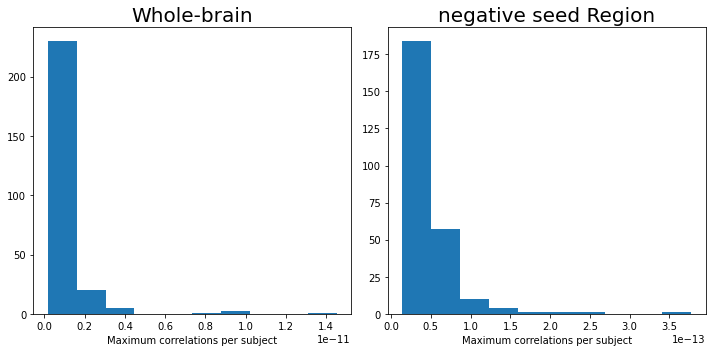

In [72]:
run_conf_denoise_seed_case(task_id = "msit", n_jobs=20)

# TASK EVENTS

Check that the ROI time series do not correlate with the task events

In [25]:
fir_delays_dict = dict() 
fir_delays_dict['3rd'] = list(range(1, 4))
fir_delays_dict['5th'] = list(range(1, 6))
fir_delays_dict['7th'] = list(range(1, 8))
fir_delays_dict['9th'] = list(range(1, 10))
fir_delays_dict['11th'] = list(range(1, 12))
print(fir_delays_dict)
       
pipe_filter_regex = "trans|rot|white_matter$|csf$"
print(pipe_filter_regex)

{'3rd': [1, 2, 3], '5th': [1, 2, 3, 4, 5], '7th': [1, 2, 3, 4, 5, 6, 7], '9th': [1, 2, 3, 4, 5, 6, 7, 8, 9], '11th': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]}
trans|rot|white_matter$|csf$


In [26]:
def get_task_regressors_dict(event_file):
    
    events = pd.read_csv(event_file, sep="\t")
    n_scans = 280
    t_r = 2.0
    start_time = 0
    end_time = (n_scans-1)*t_r

    frame_times = np.linspace(start_time, end_time, n_scans)
    
    task_hrf_dict = dict()
    plt.figure()
    for trial_type in ["Incongruent", "Congruent"]:

        exp_condition = events[events.trial_type == trial_type].loc[:, ["onset", "duration"]].to_numpy()
        n_blocks = exp_condition.shape[0]

        exp_condition = np.column_stack((exp_condition, np.array([1]*n_blocks)))
        cond_hrf = glm.first_level.compute_regressor(exp_condition.T, 
                                                     hrf_model='glover', 
                                                     frame_times=frame_times)[0]
        task_hrf_dict[trial_type]= cond_hrf
        
        plt.plot(cond_hrf, label=trial_type)
    plt.legend()
    plt.show()
    return task_hrf_dict

def edge_task_correlations(run_img, event_file, conf_df, atlas_file, task_hrf_dict, this_denoise_opts):
    
        edge_atlas = NiftiEdgeAtlas(atlas_file=atlas_file, **this_denoise_opts)
        #edge_atlas_img = edge_atlas.fit_transform(run_img=run_img, events=event_file, confounds=conf_df)
        _ = edge_atlas.fit_transform(run_img=run_img, events=event_file, confounds=conf_df)
        
        corrs_inc, pv_inc = zip(*[pearsonr(edge_atlas.atlas_roi_denoised_[:,ii], 
                                           task_hrf_dict['Incongruent'].squeeze()) \
                                  for ii in range(268)])
        
        max_cor_inc = np.max(np.abs(list(corrs_inc)))
        max_ix = np.argmax(np.abs(list(corrs_inc)))
        pv_inc_min = pv_inc[max_ix]
        
        corrs_con, pv_con = zip(*[pearsonr(edge_atlas.atlas_roi_denoised_[:,ii], 
                                           task_hrf_dict['Congruent'].squeeze()) \
                                  for ii in range(268)])
        max_cor_con = max(np.abs(list(corrs_con)))
        max_ix = np.argmax(np.abs(list(corrs_con)))
        pv_con_min = pv_con[max_ix]
        
        return max_cor_inc, pv_inc_min, max_cor_con, pv_con_min  

    
def plot_qc_cors_and_save(max_cors_inc_dict, max_cors_con_dict, output_dir):
    fig, axs = plt.subplots(ncols=2, figsize=(20,7), sharey=True)    
    plot_dat_df = pd.DataFrame(max_cors_inc_dict)
    sns.boxplot(y = "variable", x="value", data=pd.melt(plot_dat_df), orient='h', ax=axs[0])
    axs[0].set_xscale("log")
    axs[0].set_ylabel("")
    axs[0].set_xlabel("Max Pearson correlation per subject", size=25)
    axs[0].tick_params(labelsize=20)
    axs[0].set_title("Incongruent", size=30)

    plot_dat_df = pd.DataFrame(max_cors_con_dict)
    sns.boxplot(y = "variable", x="value", data=pd.melt(plot_dat_df), orient='h', ax=axs[1])
    axs[1].set_xscale("log")
    axs[1].set_ylabel("")
    axs[1].set_xlabel("Max Pearson correlation per subject", size=25)
    axs[1].tick_params(labelsize=20)
    axs[1].set_title("Congruent", size=30)

    #plt.savefig(opj(output_dir, "task_denoise_cors_qc.png"), dpi=300)

def plot_qc_pvals_and_save(pv_inc_dict, pv_con_dict, output_dir):
    fig, axs = plt.subplots(ncols=2, figsize=(20,7), sharey=True)    
    plot_dat_df = pd.DataFrame(pv_inc_dict)
    sns.ecdfplot(hue = "FIR_delay", x="value", data=pd.melt(plot_dat_df, var_name="FIR_delay"), ax=axs[0])
    axs[0].set_ylabel("ECDF", size=25)
    axs[0].set_xlabel("p-value per subject", size=25)
    axs[0].tick_params(labelsize=20)
    axs[0].set_title("Incongruent", size=30)

    plot_dat_df = pd.DataFrame(pv_con_dict)
    sns.ecdfplot(hue = "FIR_delay", x="value", data=pd.melt(plot_dat_df, var_name="FIR_delay"),  ax=axs[1])
    axs[1].set_ylabel("ECDF", size=25)
    axs[1].set_xlabel("p-value per subject", size=25)
    axs[1].tick_params(labelsize=20)
    axs[1].set_title("Congruent", size=30)

    #plt.savefig(opj(output_dir, "task_denoise_pvas_qc.png"), dpi=300)

    
def compute_max_corrs(run_imgs, event_file, confounders_df, atlas_file, denoise_opts):
    
    task_hrf_dict = get_task_regressors_dict(event_file)

    # Build task regressors
    parallel = Parallel(n_jobs=20)

    # Initialize dictionaries
    max_cors_inc_dict = dict()
    max_cors_con_dict = dict()
    pv_inc_dict = dict()
    pv_con_dict = dict()
    
    # First case: No task regressor denoise
    res_cors = parallel(delayed(edge_task_correlations)(run_img = run_img, 
                                                        event_file = None, 
                                                        conf_df = conf_df, 
                                                        atlas_file = atlas_file, 
                                                        task_hrf_dict = task_hrf_dict,
                                                        this_denoise_opts = denoise_opts) \
                            for run_img, conf_df in zip(run_imgs, confounders_df)
                           )
    max_cors_inc, pv_inc_min, max_cors_con, pv_con_min = zip(*res_cors)
    
    max_cors_inc_dict["no-denoise"] = max_cors_inc
    max_cors_con_dict["no-denoise"] = max_cors_con
    pv_inc_dict["no-denoise"] = pv_inc_min
    pv_con_dict["no-denoise"] = pv_con_min
    
    for case, fir_delays in tqdm(fir_delays_dict.items()):

        this_denoise_opts = denoise_opts.copy()
        this_denoise_opts['fir_delays'] = fir_delays

        res_cors = parallel(delayed(edge_task_correlations)(run_img = run_img, 
                                                            event_file = event_file, 
                                                            conf_df = conf_df, 
                                                            atlas_file = atlas_file, 
                                                            task_hrf_dict = task_hrf_dict,
                                                            this_denoise_opts = this_denoise_opts) \
                            for run_img, conf_df in zip(run_imgs, confounders_df)
                           )
        max_cors_inc, pv_inc_min, max_cors_con, pv_con_min = zip(*res_cors)
        
        max_cors_inc_dict[case] = max_cors_inc
        max_cors_con_dict[case] = max_cors_con
        pv_inc_dict[case] = pv_inc_min
        pv_con_dict[case] = pv_con_min
        
    return max_cors_inc_dict, pv_inc_dict, max_cors_con_dict, pv_con_dict
    
def run_task_qc_case(task_id):
    
    # Get files and confounders dataframes
    print("running task denoising QC for task %s" % task_id)
    run_img_pattern, confounders_pattern = get_patterns(task_id)
    
    run_imgs = [run_img_pattern % subj for subj in subjects_used]
    confounders_df = [pd.read_csv(confounders_pattern % subj, sep="\t") for subj in subjects_used]
    confounders_df = [conf_df.filter(regex=pipe_filter_regex).fillna(0) for conf_df in confounders_df]
    event_file = "../data/task-%s_events.tsv" % task_id
    # Compute maximum correlations per subject
    max_cors_inc_dict, pv_inc_dict, max_cors_con_dict, pv_con_dict = compute_max_corrs(run_imgs, 
                                                                                       event_file, 
                                                                                       confounders_df, 
                                                                                       atlas_file, 
                                                                                       denoise_opts)
    # Save plots
    output_dir = "../plots/qc/task-%s" % task_id
    Path(output_dir).mkdir(parents=True, exist_ok=True)
    plot_qc_cors_and_save(max_cors_inc_dict, max_cors_con_dict, output_dir)
    plot_qc_pvals_and_save(pv_inc_dict, pv_con_dict, output_dir)

running task denoising QC for task stroop


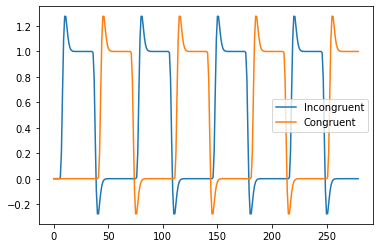

100%|██████████| 5/5 [14:13<00:00, 170.61s/it]


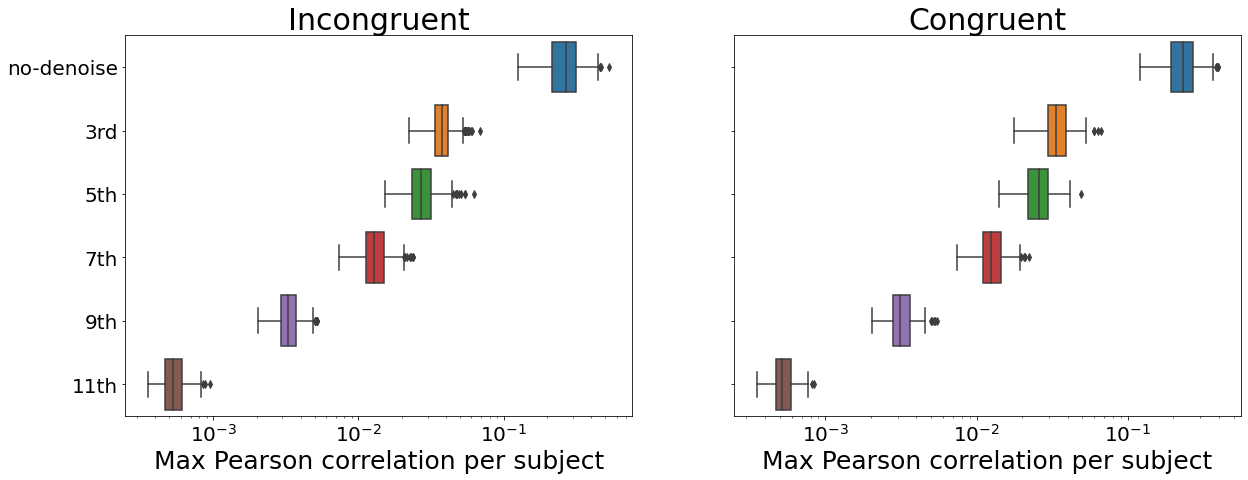

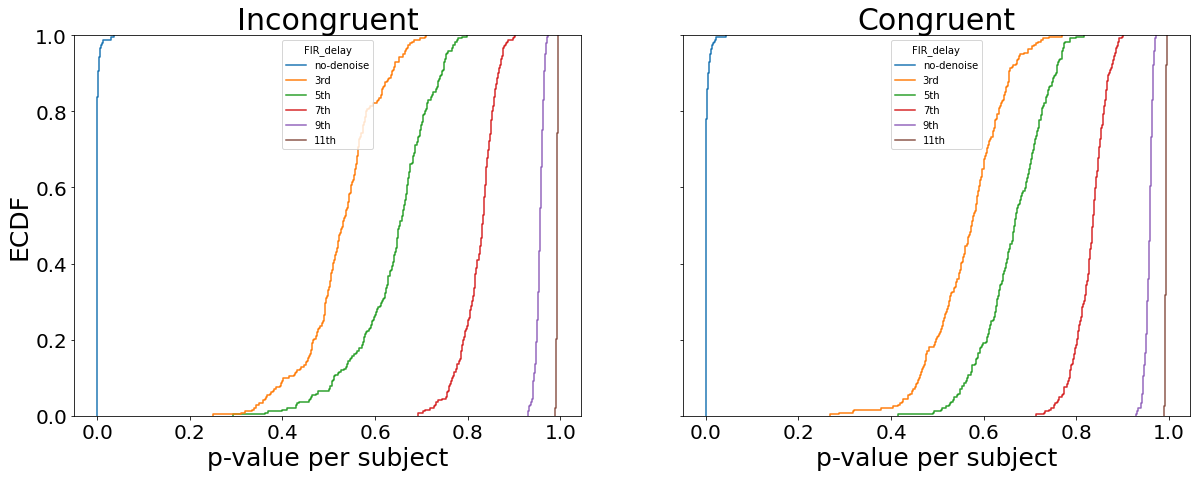

In [27]:
run_task_qc_case("stroop")

running task denoising QC for task msit


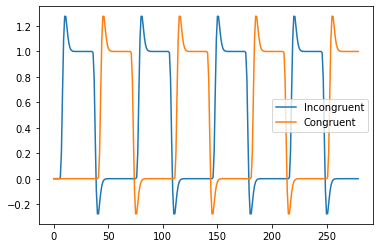

100%|██████████| 5/5 [13:50<00:00, 166.02s/it]


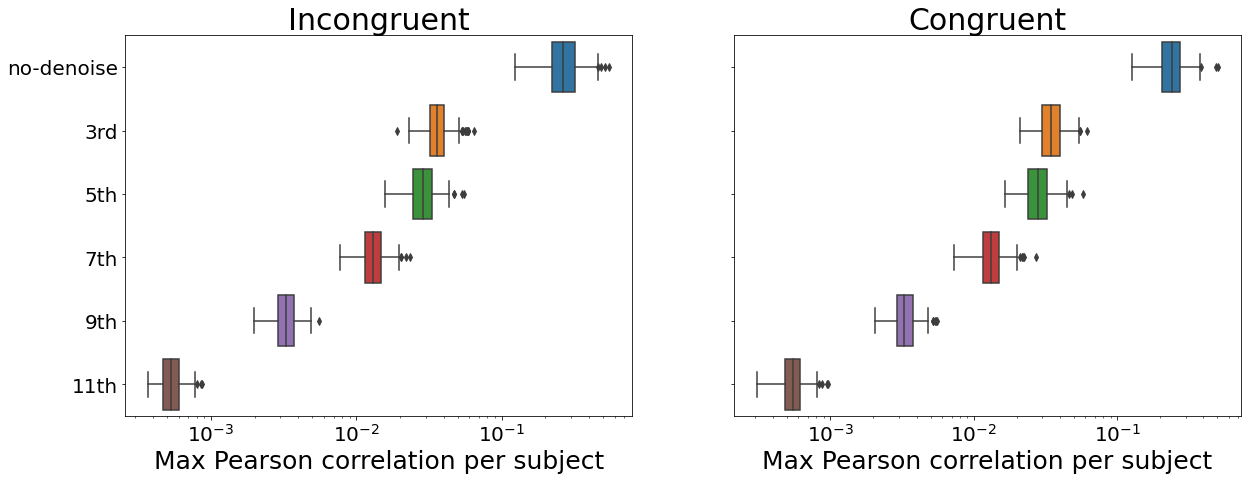

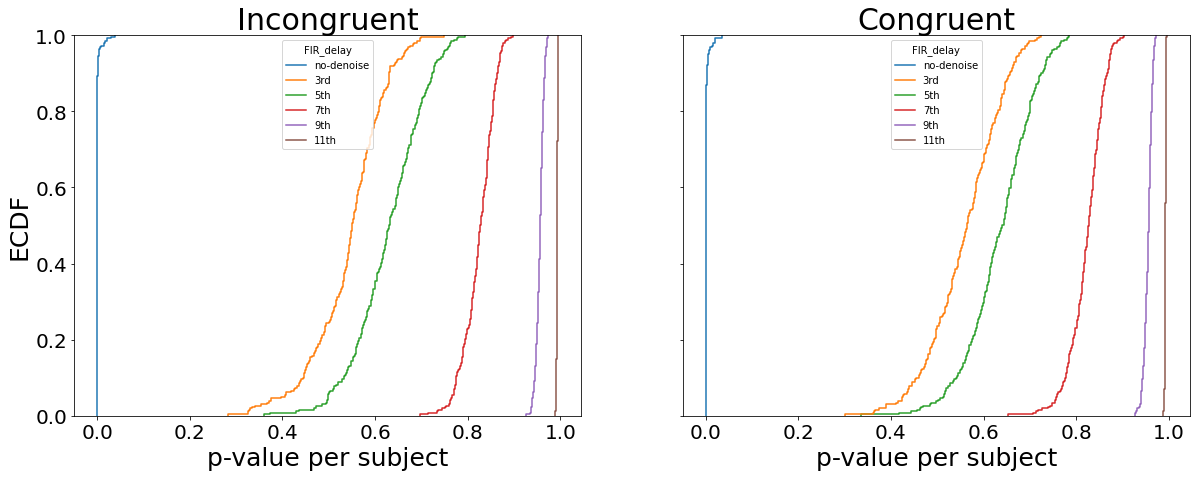

In [27]:
run_task_qc_case("msit")